### Creating a mask of urban areas in a landsat image


In [4]:
import os
import warnings
from pprint import pprint

In [2]:
import descarteslabs as dl

First let's load a landuse map. 

In [5]:
# Find potential matches
matches = dl.places.find('new-mexico_taos')
pprint(matches)
# The first one looks good to me, so lets make that our area of interest.
aoi = matches[0]


[{'bbox': [-106.058364, 36.013014, -105.200117, 36.995841],
  'id': 102081181,
  'name': 'Taos',
  'path': 'continent:north-america_country:united-states_region:new-mexico_district:northwest_county:taos',
  'placetype': 'county',
  'slug': 'north-america_united-states_new-mexico_northwest_taos'}]


This area of interest just gives us some basic properties such as bounding boxes.
To access a GeoJSON Geometry object of that place, we call the `Places.shape` method, in this case
accessing a low-resolution version of this particular shape.



In [6]:
shape = dl.places.shape(aoi['slug'], geom='low')

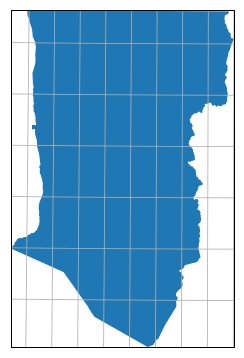

In [7]:
# If you'd like, load up some libraries like matplotlib, shapley, and cartopy,
# and use them to plot Taos county.
#%matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt
import shapely.geometry
import cartopy

bbox = shape['bbox']

# Lets load up the Albers Equal Area projection.
lonlat_crs = cartopy.crs.PlateCarree()
albers = cartopy.crs.AlbersEqualArea(central_latitude=36.0, central_longitude=-105)

fig = plt.figure(figsize=(4, 8))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])

# When adding a geometry in latlon coordinates, specify the latlon projection
ax.add_geometries([shp], lonlat_crs)

# You can set extents in latlon, as long as you specify the projection with `crs`
ax.set_extent((bbox[0], bbox[2], bbox[1], bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()


## Searching for available imagery

In [8]:
# What imagery is available?
sources = dl.metadata.sources()
pprint(sources)

[{'product': 'modis:09:CREFL', 'sat_id': 'Terra'},
 {'product': 'modis:09:CREFL', 'sat_id': 'Aqua'},
 {'product': 'sentinel-2:L1C', 'sat_id': 'S2A'},
 {'product': 'sentinel-2:L1C', 'sat_id': 'S2B'},
 {'product': 'landsat:LE07:PRE:TOAR', 'sat_id': 'LANDSAT_7'},
 {'product': 'landsat:LE07:PRE:TOAR', 'sat_id': 'Landsat7'},
 {'product': 'landsat:LT05:PRE:TOAR', 'sat_id': 'LANDSAT_5'},
 {'product': 'landsat:LT05:PRE:TOAR', 'sat_id': 'Landsat5'},
 {'product': 'sentinel-3:OLCI_RGB', 'sat_id': 'S3A'},
 {'product': 'landsat:LC08:PRE:TOAR', 'sat_id': 'LANDSAT_8'},
 {'product': 'sentinel-1:GRD', 'sat_id': 'SENTINEL-1A'},
 {'product': 'sentinel-1:GRD', 'sat_id': 'SENTINEL-1B'},
 {'product': '5151d2825f5e29ff129f86d834946363ff3f7e57:modis:09:CREFL_v2_test',
  'sat_id': 'Aqua'},
 {'product': '5151d2825f5e29ff129f86d834946363ff3f7e57:modis:09:CREFL_v2_test',
  'sat_id': 'Terra'},
 {'product': 'usda:naip:rgbn', 'sat_id': 'NAIP'},
 {'product': 'usda:naip:rgbn:v1', 'sat_id': 'NAIP'},
 {'product': 'lands

## Let's find some Landsat 8 imagery over our AOI

In [11]:
import json
feature_collection = dl.metadata.search(products='landsat:LC08:PRE:TOAR', start_time='2017-03-12',
                                        end_time='2017-03-20', limit=10, place=aoi['slug'])
# As the variable name implies, this returns a FeatureCollection GeoJSON dictionary.
# Its 'features' are the available scenes.
print (len(feature_collection['features']))
# The 'id' associated with each feature is a unique identifier into our imagery database.
# In this case there are two L8 scenes from adjoining WRS rows.
print ([f['id'] for f in feature_collection['features']])


2
['landsat:LC08:PRE:TOAR:meta_LC80330342017072_v1', 'landsat:LC08:PRE:TOAR:meta_LC80330352017072_v1']


In [12]:
# Lets look at the first feature. The features are a FeatureCollection,
# so if we print it out we get a bunch of information. For example, we see that
# the overall cloud fraction is 1.2%.:
f0 = feature_collection['features'][0]
pprint(f0)

{'geometry': {'coordinates': [[[-105.8898318, 38.5103536],
                               [-103.8445201, 38.1129959],
                               [-104.3838427, 36.4246539],
                               [-106.377808, 36.8201224],
                               [-105.8898318, 38.5103536]]],
              'type': 'Polygon'},
 'id': 'landsat:LC08:PRE:TOAR:meta_LC80330342017072_v1',
 'key': 'meta_LC80330342017072_v1',
 'properties': {'acquired': '2017-03-13T17:37:50.132812Z',
                'area': 35462.0,
                'bits_per_pixel': [1.463, 1.778, 0.922],
                'bright_fraction': 0.1168,
                'bucket': 'gs://descartes-l8/',
                'cloud_fraction': 0.1907,
                'cloud_fraction_0': 0.0643,
                'cs_code': 'EPSG:32613',
                'descartes_version': 'hedj-landsat-0.9.7.4',
                'file_md5s': ['e084f11d78cedb76968959231e598112',
                              'd8970e1688a8a97e09f9f4eace81edf6'],
                

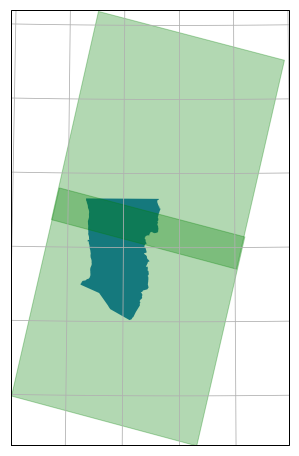

In [13]:
# Let's plot the footprints of the scenes:
lonlat_crs = cartopy.crs.PlateCarree()
albers = cartopy.crs.AlbersEqualArea(central_latitude=36.0, central_longitude=-105)

fig = plt.figure(figsize=(6, 8))
ax = plt.subplot(projection=albers) # Specify projection of the map here

ax.add_geometries([shapely.geometry.shape(shape['geometry'])],
                   lonlat_crs)

# Get the geometry from each feature
shapes = [shapely.geometry.shape(f['geometry']) for
          f in feature_collection['features']]

ax.add_geometries(shapes, lonlat_crs, alpha=0.3, color='green')

# Get a bounding box of the combined scenes
union = shapely.geometry.MultiPolygon(polygons=shapes)
bbox = union.bounds
ax.set_extent((bbox[0], bbox[2], bbox[1], bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)

plt.show()

## What bands are available

In [33]:
# band_information = dl.metadata.bands("LC08")
# or
band_information = dl.metadata.get_bands_by_key(feature_collection['features'][0]['id'])
pprint(band_information.keys())

dict_keys(['alpha', 'bai', 'blue', 'bright-mask', 'cirrus', 'cloud-mask', 'coastal-aerosol', 'evi', 'green', 'ndvi', 'ndwi', 'ndwi1', 'ndwi2', 'nir', 'qa_cirrus', 'qa_cloud', 'qa_snow', 'qa_water', 'red', 'rsqrt', 'swir1', 'swir2', 'tirs1', 'visual_cloud_mask'])


In [34]:
print(band_information['ndvi'])

{'bands': ['nir', 'red'], 'data_range': [0, 65535], 'description': 'Normalized Difference Vegetation Index', 'dtype': 'UInt16', 'function_name': 'ndi_uint16', 'id': 'derived:ndvi', 'name': 'ndvi', 'name_common': 'ndvi', 'physical_range': [-1.0, 1.0]}


## Rasterizing imagery

In [16]:
# Collect the id's for each feature
ids = [f['id'] for f in feature_collection['features']]
# Rasterize the features.
#  * Select red, green, blue, alpha
#  * Scale the incoming data with range [0, 10000] down to [0, 4000] (40% TOAR)
#  * Choose an output type of "Byte" (uint8)
#  * Choose 60m resolution
#  * Apply a cutline of Taos county
arr, meta = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Byte',
    resolution=60,
    cutline=shape['geometry'],
)

# Note: A value of 1 in the alpha channel signifies where there is valid data.
# We use this throughout the majority of our imagery as a standard way of specifying
# valid or nodata regions. This is particularly helpful if a value of 0 in a particular
# band has meaning, rather than specifying a lack of data.


In [17]:
# We'll use matplotlib to make a quick plot of the image.
import matplotlib.pyplot as plt
%matplotlib inline


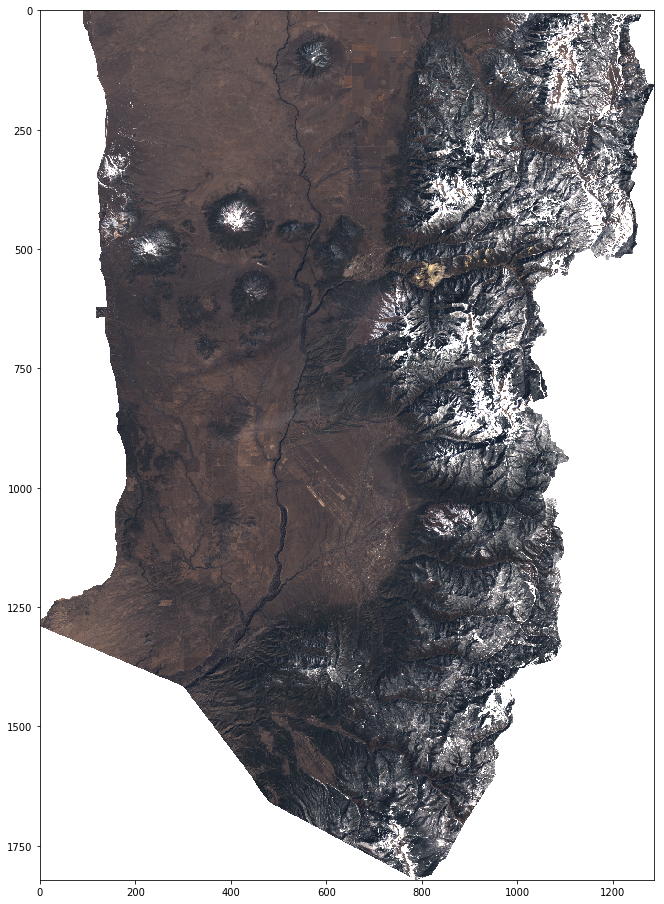

In [18]:
plt.figure(figsize=[16,16])
plt.imshow(arr)

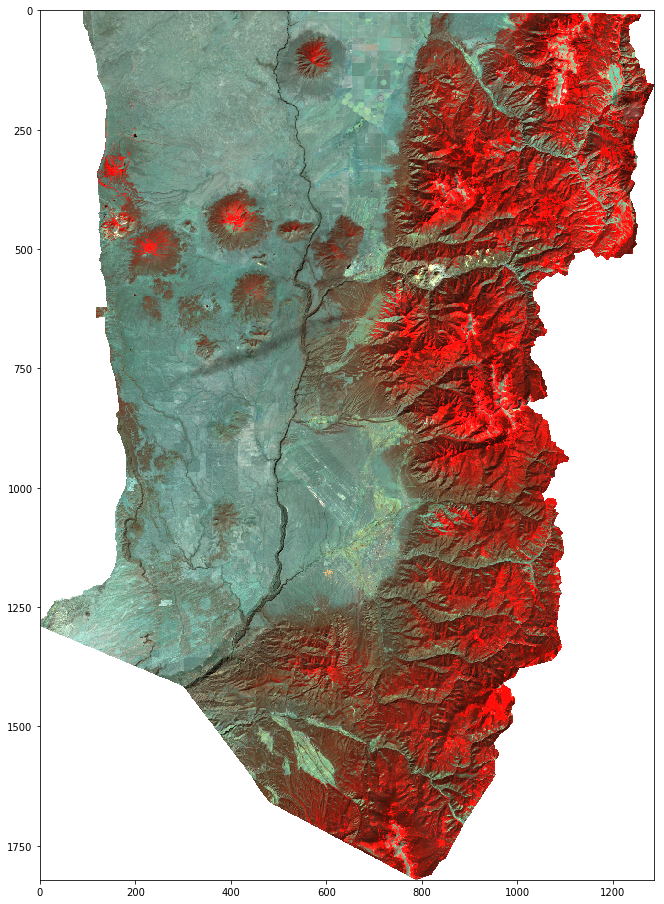

In [19]:
# We can choose other false color band combinations, like
# NIR - SWIR1 - SWIR2
arr, meta = dl.raster.ndarray(
    ids,
    bands=['nir', 'swir1', 'swir2', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    cutline=shape['geometry'],
    data_type='Byte',
    resolution=60
)
plt.figure(figsize=[16,16])
plt.imshow(arr)

In [27]:
pprint(band_information['ndvi'])

{'bands': ['nir', 'red'],
 'data_range': [0, 65535],
 'description': 'Normalized Difference Vegetation Index',
 'dtype': 'UInt16',
 'function_name': 'ndi_uint16',
 'id': 'derived:ndvi',
 'name': 'ndvi',
 'name_common': 'ndvi',
 'physical_range': [-1.0, 1.0]}


In [35]:
# Or even derived bands like NDVI. Here the alpha channel comes in
# particularly useful as a way to select valid data. Here you may want to use
# some of the band information to scale NDVI properly.

valid_range = band_information['ndvi']['data_range']
physical_range = band_information['ndvi']['physical_range']
print ("%s maps to %s" % (valid_range, physical_range))
arr, meta = dl.raster.ndarray(
    [f['id'] for f in feature_collection['features']],
    bands=['ndvi', 'alpha'],
    scales=[[valid_range[0], valid_range[1], physical_range[0], physical_range[1]], None],
    cutline=shape['geometry'],
    data_type='Float32',
    resolution=60
)


[0, 65535] maps to [-1.0, 1.0]


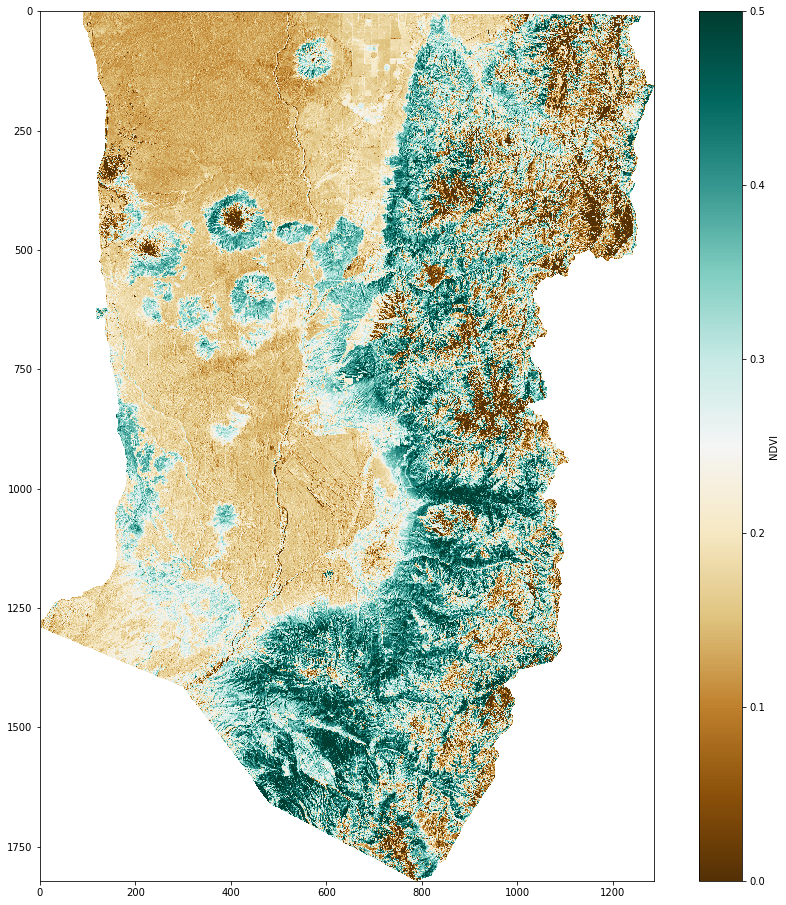

In [36]:
# Here we can make a numpy masked array using alpha == 0 as a nodata mask.
import numpy as np
mask = arr[:, :, 1] == 0
masked_ndvi = np.ma.masked_array(arr[:, :, 0], mask)
plt.figure(figsize=[16,16])
plt.imshow(masked_ndvi, cmap='BrBG', vmin=0, vmax=0.5)
cb = plt.colorbar()
cb.set_label("NDVI")

In [46]:
x = np.array([1, 2, 3, 99, 5, 6, 99])
y = np.ma.masked_values(x, 2)
print(y)
print(y[3])

[1 -- 3 99 5 6 99]
99


In [59]:
matches = dl.places.find('maryland')
aoi = matches[0] 
shape = dl.places.shape(aoi['slug'], geom='low')


In [60]:
import json

sentinel_data = 'sentinel-1:GRD','sentinel-1:GRD'

feature_collection = dl.metadata.search(products= sentinel_data, start_time='2017-03-12',
                                        end_time='2017-03-20', limit=10, place=aoi['slug'])
# As the variable name implies, this returns a FeatureCollection GeoJSON dictionary.
# Its 'features' are the available scenes.
print (len(feature_collection['features']))
# The 'id' associated with each feature is a unique identifier into our imagery database.
# In this case there are two L8 scenes from adjoining WRS rows.
print ([f['id'] for f in feature_collection['features']])

4
['sentinel-1:GRD:meta_2017-03-16_077A1502_S1A', 'sentinel-1:GRD:meta_2017-03-16_077A1527_S1A', 'sentinel-1:GRD:meta_2017-03-18_106A5821_S1A', 'sentinel-1:GRD:meta_2017-03-18_106A5846_S1A']


In [62]:
pprint([f for f in feature_collection['features']])

[{'geometry': {'coordinates': [[[-81.059074, 39.251652],
                                [-78.100685, 39.653793],
                                [-77.783859, 38.153271],
                                [-80.680634, 37.749889],
                                [-81.059074, 39.251652]]],
               'type': 'Polygon'},
  'id': 'sentinel-1:GRD:meta_2017-03-16_077A1502_S1A',
  'key': 'meta_2017-03-16_077A1502_S1A',
  'properties': {'acquired': '2017-03-16T23:15:02.423628Z',
                 'area': 42529.6,
                 'bpp': [12.292, 13.171],
                 'bucket': 'gs://descartes-s1a/',
                 'cs_code': 'EPSG:32617',
                 'descartes_version': 'satin-0.8.7',
                 'duration': 24.998772,
                 'file_md5s': ['d4831758c361671a7331e85ee6cc2f88',
                               '702b187999fe34124690529087972ae4'],
                 'file_sizes': [163356121, 175036721],
                 'files': ['2017-03-16_077A1502_S1A_vv.tif',
          